In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.dates import num2date, date2num
warnings.simplefilter("ignore")
%matplotlib inline

import yfinance as yf

In [26]:
from vertica_python import connect
import datetime
from time import time
import os
import config_vertica
import pandas as pd

host=config_vertica.office_host
user=config_vertica.user.casefold()
passwd=config_vertica.password

# office-vrt
conn_info = {'host': ,#bring host data
             'port': ,#bring port data
             
             'user': user,
             'password': passwd,
             'database': 'taboola_prod',
             # autogenerated session label by default,
             'session_label': 'some_label',
             # default throw error on invalid UTF-8 results
             'unicode_error': 'strict',
             # SSL is disabled by default
             'ssl': False,
             # autocommit is off by default
             'autocommit': True,
             # using server-side prepared statements is disabled by default
             'use_prepared_statements': False,
             # connection timeout is not enabled by default
             # 5 seconds timeout for a socket operation (Establishing a TCP connection or read/write operation)
             'connection_timeout': 3000}

connection = connect(**conn_info)
cur = connection.cursor()

## Import Data

In [2]:
my_stocks = ('ESLT.TA','ICLN','DSCT.TA','SGOL','PERI','IWM','US500','TBLA')

other_stocks = ('RTPT-L.TA','DLEKG.TA')

In [3]:
# show financials
ticker='TBLA'
tickerData = yf.Ticker(ticker)
#tickerData.financials
#tickerData.quarterly_financials
tickerData.institutional_holders

,Date Reported,Holder,pctHeld,Shares,Value
0,2023-06-30,"Invus Financial Advisors, LLC",0.8072,9969495,31005129
1,2023-06-30,Phoenix Holdings Ltd.,0.4227,5219777,16233506
2,2023-06-30,G2 Investment Partners Management LLC,0.3165,3908420,12155186
3,2023-06-30,Migdal Insurance & Financial Holdings Ltd.,0.2480,3063235,9526660
4,2023-06-30,Blackrock Inc.,0.1708,2109642,6560986
5,2023-06-30,Ardsley Advisory Partners,0.1626,2007500,6243325
6,2023-06-30,Menora Mivtachim Holdings Ltd.,0.1498,1850000,5753500
7,2023-06-30,Potrero Capital Research LLC,0.1464,1808354,5623980


## Upload Stock Data to Vertica

In [130]:
# Main Markets

tickers = {'^GSPC' :'S&P500'
           ,'TBLA' : 'Taboola'
           ,'^FTSE' :'UK'
           ,'^FCHI' :'CAC 40'
           ,'IMOEX.ME' : 'Russia'
           ,'^N225' :'Nikkey 225'
           ,'^KS11' :'Kospi' 
           ,'^TA125.TA' :'Israel',
           '^BVSP' :'Bovespa' 
           ,'^MERV':'Merval'
          }

In [131]:
#Load the data of the different markets and upload to DB

for k in tickers:
    print(k,'-',tickers[k])
    tickerData = yf.Ticker(k)
    time.sleep(2)
    df = tickerData.history(period='1d', start='2017-01-01')
    df.reset_index(inplace=True)
    del df['Dividends']
    del df['Stock Splits']
    df['ticker'] = k
    df['market'] = tickers[k]
    sub = df[['Date','Open','High','Low','Close','Volume','ticker','market']].reset_index(drop=True)
   
    #fill gaps with previous value
    idx = pd.period_range(min(sub['Date']),datetime.today())
    data = {'Date': idx}
    all_dates = pd.DataFrame(data=data)
    all_dates['Date'] = all_dates['Date'].values.astype('datetime64[ns]')

    unifyDF = all_dates.merge(sub, on='Date', how='left')

    unifyDF.fillna(method='ffill', inplace=True)
    
    #save file and load it to vertica
    unifyDF.to_csv('/Users/diego.n/markets/'+ tickers[k] +'.csv',index=False)
    
    with open('/Users/diego.n/markets/'+ tickers[k] +'.csv', "rb") as fs:
        my_file = fs.read()
        cur.copy(
            "COPY analysts.forecast_stock_market FROM STDIN PARSER FDELIMITEDPARSER (delimiter=',', "
            "header='true') ",
            my_file)  # buffer_size=65536

^BVSP - Bovespa
^MERV - Merval


In [31]:
#df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].values.astype('datetime64[ns]')

In [121]:
import time
time.sleep(3)

## Stock Analysis

In [37]:
ticker = 'TBLA'
tickerData = yf.Ticker(ticker)
df = tickerData.history(period='1d', start='2022-01-01')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-01-03 00:00:00-05:00,7.59,7.900,7.36,7.64,966300,0.0,0.0
2022-01-04 00:00:00-05:00,7.68,7.865,7.21,7.28,1077400,0.0,0.0
2022-01-05 00:00:00-05:00,7.30,7.480,6.95,6.95,801400,0.0,0.0
2022-01-06 00:00:00-05:00,6.87,7.120,6.67,6.71,1453400,0.0,0.0
2022-01-07 00:00:00-05:00,6.72,6.900,6.69,6.74,873800,0.0,0.0
...,...,...,...,...,...,...,...
2024-01-12 00:00:00-05:00,4.23,4.299,4.14,4.16,623800,0.0,0.0
2024-01-16 00:00:00-05:00,4.13,4.130,4.04,4.09,1047700,0.0,0.0
2024-01-17 00:00:00-05:00,4.00,4.040,3.96,4.00,1355100,0.0,0.0


## RSI

Another commonly used indicator is a Relative Strength Index (RSI) that indicates magnitude of recent price changes. It can show that a stock is either overbought or oversold. Typically RSI value of 70 and above signal that a stock is becoming overbought/overvalued, meanwhile value of 30 and less can mean that it is oversold. Full range of RSI is from 0 to 100.

In [38]:
def rsi(df, window=14):
    close = df['Close']
    
    # Price increase or decrease over previous day
    dif = close.diff()
    dif = dif[1:] 
    
    # pos_m identifies stock price going up
    # neg_m udentifies stock price going down
    pos_m, neg_m = dif.copy(), dif.copy()
    pos_m[pos_m < 0] = 0
    neg_m[neg_m > 0] = 0
    
    # Positive Rolling Mean Exponential
    prme = pos_m.ewm(span=window).mean()
    # Negative Rolling Mean Exponential
    nrme = neg_m.abs().ewm(span=window).mean()
    
    # Ratio of magnitude of up move to down move
    RSE = prme / nrme
    RSIE = 100.0 - (100.0 / (1.0 + RSE))
    df['rsie'] = RSIE
    
    # Positive Rolling Mean Simple
    prms = pos_m.rolling(window).mean()
    # Negative Rolling Mean Simple
    nrms = neg_m.abs().rolling(window).mean()

    RSS = prms / nrms
    RSIS = 100.0 - (100.0 / (1.0 + RSS))
    
    df['rsis'] = RSIS
    return df

In [39]:
def candlestick(ax, quotes, width=0.2, colorup='g', colordown='r', alpha=1.0):
    OFFSET = width / 2.0

    lines = []
    patches = []
    for q in quotes:
        t, open, close, high, low = q[:5]

        if close >= open:
            color = colorup
            lower = open
            height = close - open
        else:
            color = colordown
            lower = close
            height = open - close

        vline = Line2D(
            xdata=(t, t), ydata=(low, high),
            color=color,
            linewidth=0.5,
            antialiased=True)

        rect = Rectangle(
            xy=(t - OFFSET, lower),
            width=width,
            height=height,
            facecolor=color,
            edgecolor=color)
        rect.set_alpha(alpha)

        lines.append(vline)
        patches.append(rect)
        ax.add_line(vline)
        ax.add_patch(rect)
    ax.autoscale_view()

    return lines, patches

In [53]:
def plot_rsi(df, start_date='2022-05-01'#, end_date='2021-09-30'
            ):
    plt.rcParams['figure.figsize'] = [24, 12]
    fig = plt.figure()
    df = df[(df.index>=start_date) #& (df.index<=end_date)
           ]
    ax1 = plt.subplot2grid((5,4), (0,0), rowspan=4, colspan=4)
    
    candlestick(ax1, np.array(df[['DateY', 'Open', 'Close', 'High', 'Low']]))
    plt.title(ticker + " Price/RSI chart", fontsize=20)
    plt.ylabel("Price")
    ax1.grid(True)
    
    ax2 = plt.subplot2grid((5,4), (4,0), rowspan=1, colspan=4, sharex=ax1)
    ax2.fill_between(num2date(df['DateY']), 30, 70, color = '#eeeee4')
    ax2.plot(num2date(df['DateY']), df['rsie'])
    plt.ylabel("RSI")
    ax2.grid(True)
    
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.subplots_adjust(hspace=0)

In [41]:
df = rsi(df)

In [54]:
df['Date'] = df.index
df['DateY'] = df['Date'].apply(lambda x: date2num(datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")))

In [56]:
# over 70 over bought - down 30 over sold
#plot_rsi(df)

In [30]:
## Loop for all stock
# for stock in my_stocks:
#     print(stock)
#     tickerData = yf.Ticker(stock)
#     df = tickerData.history(period='1d', start='2020-09-10')
#     df = rsi(df)
#     df['Date'] = df.index
#     df['DateY'] = df['Date'].apply(lambda x: date2num(datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")))
#     plot_rsi(df)

## Moving Averages

Moving Averages (MA) help to smooth out stock prices on a chart by filtering out short-term price fluctuations. We calculate moving averages over a defined period of time e.g. last 9, 50 or 200 days. There are two (most common) averages used in technical analysis which are:

Simple Moving Average (SMA) - a simple average calculated over last N days e.g. 50, 100 or 200,
Exponential Moving Average (EMA) - an average where greater weights are applied to recent prices.
MAs and their crossovers (see Golden Cross and Death Cross are often used as trade signals as they are so simple yet powerful.

In [14]:
import os
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.io as pio
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

def plot_scatter(x, y, title):
    fig = go.Figure(go.Scatter(x=x, y=y, name=title))
    fig.update_layout(title_text=title)
    fig.show()

In [44]:
df['Date'] = df.index
df['EMA_9'] = df['Close'].ewm(5).mean().shift()
df['SMA_50'] = df['Close'].rolling(50).mean().shift()
df['SMA_100'] = df['Close'].rolling(100).mean().shift()
df['SMA_200'] = df['Close'].rolling(200).mean().shift()

In [45]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_50, name='SMA 50'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_100, name='SMA 100'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_200, name='SMA 200'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', line_color='dimgray', opacity=0.3))
fig.show()

## MACD

Moving Average Convergence Divergence (MACD) is an indicator which shows the relationship between two exponential moving averages i.e. 12-day and 26-day EMAs. We obtain MACD by substracting 26-day EMA (also called slow EMA) from the 12-day EMA (or fast EMA).

In [17]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
MACD = pd.Series(EMA_12 - EMA_26)
MACD_signal = pd.Series(MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=MACD, name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=MACD_signal, name='Signal line'), row=2, col=1)
fig.show()

## Bollinger bands

In [18]:
import matplotlib.dates as mpl_dates
from mpl_finance import candlestick_ohlc

/Users/diego.n/opt/anaconda3/lib/python3.8/site-packages/mpl_finance.py:16: DeprecationWarning:





    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/





In [22]:
def plot_bollinger_band(df, start_date='2022-05-01', end_date='2023-09-30'
                       ):
    plt.figure()
    plt.rcParams['figure.figsize'] = [20, 10]
    df = df[(df.index>start_date) #& (df.index<end_date)
           ]
    date = df.index
    df['Date'] = df.index
    ohlc = df[['Date', 'Open', 'High', 'Low', 'Close']]
    ohlc['Date'] = pd.to_datetime(ohlc['Date'])
    ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
    ohlc = ohlc.astype(float)
    fig, ax = plt.subplots()
    b_mean = df['Rolling Mean']
    b_high = df['Bollinger High']
    b_low = df['Bollinger Low']
    plt.plot(date, b_mean, 'k-')
    plt.fill_between(date, b_low, b_high, color = '#eeeee4')
    candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)
    plt.title("Bollinger Band")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()

In [48]:
### Bollinger Bands
window = 20
no_of_std = 2

#Calculate rolling mean and standard deviation using number of days set above
rolling_mean = df['Close'].rolling(window).mean()
rolling_std = df['Close'].rolling(window).std()
rolling_vol = df['Volume'].rolling(window).mean()

#create two new DataFrame columns to hold values of upper and lower Bollinger bands
df['Rolling Mean'] = rolling_mean
df['Bollinger High'] = rolling_mean + (rolling_std * no_of_std)
df['Bollinger Low'] = rolling_mean - (rolling_std * no_of_std)
df['Rolling Vol'] = rolling_vol

<Figure size 1728x864 with 0 Axes>

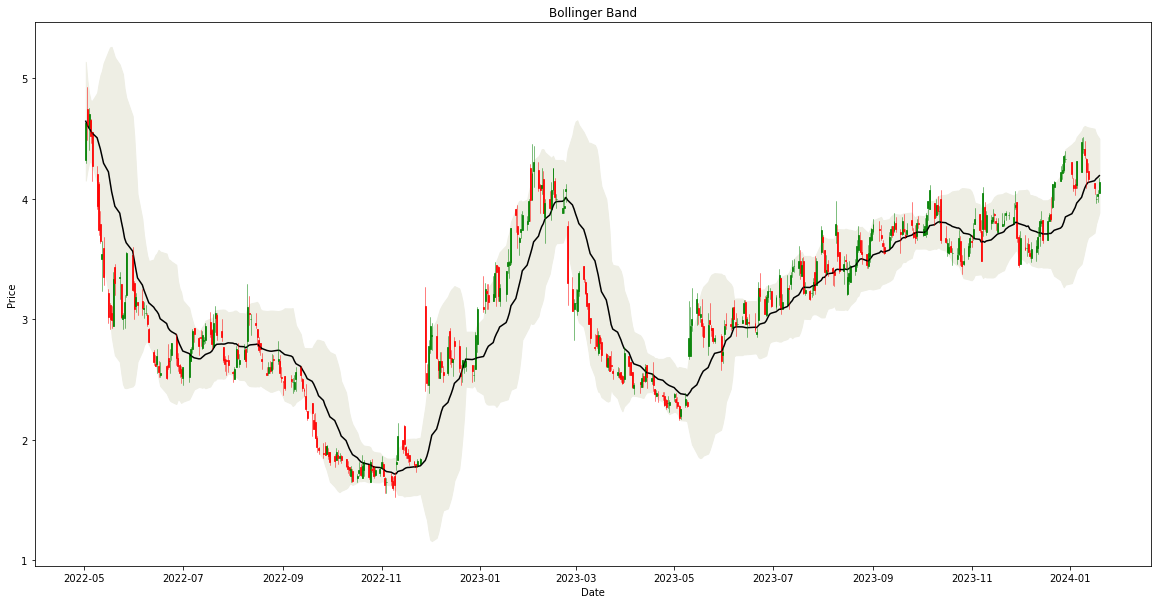

In [49]:
plot_bollinger_band(df)

In [50]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,rsie,rsis,Date,EMA_9,SMA_50,SMA_100,SMA_200,Rolling Mean,Bollinger High,Bollinger Low,Rolling Vol
Date,,,,,,,,,,,,,,,,,,
2022-01-03 00:00:00-05:00,7.59,7.900,7.36,7.64,966300,0.0,0.0,NaN,NaN,2022-01-03 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04 00:00:00-05:00,7.68,7.865,7.21,7.28,1077400,0.0,0.0,0.000000,NaN,2022-01-04 00:00:00-05:00,7.640000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-05 00:00:00-05:00,7.30,7.480,6.95,6.95,801400,0.0,0.0,0.000000,NaN,2022-01-05 00:00:00-05:00,7.443636,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-06 00:00:00-05:00,6.87,7.120,6.67,6.71,1453400,0.0,0.0,0.000000,NaN,2022-01-06 00:00:00-05:00,7.248352,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-07 00:00:00-05:00,6.72,6.900,6.69,6.74,873800,0.0,0.0,4.165398,NaN,2022-01-07 00:00:00-05:00,7.075052,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
tickerData.financials

,2022-12-31,2021-12-31,2020-12-31
Tax Effect Of Unusual Items,0.0,0.0,0.0
Tax Rate For Calcs,0.21,0.27,0.27
Normalized EBITDA,77556000.0,39846000.0,60150000.0
Net Income From Continuing Operation Net Minority Interest,-11975000.0,-24948000.0,8493000.0
Reconciled Depreciation,91221000.0,53111000.0,33957000.0
Reconciled Cost Of Revenue,936897000.0,937387000.0,869396000.0
EBITDA,77556000.0,39846000.0,60150000.0
EBIT,-13665000.0,-13265000.0,26193000.0
Net Interest Income,9213000.0,11293000.0,-2753000.0
Interest Expense,NaN,NaN,2753000.0


In [68]:
# Specify keys you want to retrieve
keys_to_retrieve = ['longName','currentPrice','priceToBook', 'enterpriseValue','shortRatio','enterpriseValue',
                   'recommendationKey','numberOfAnalystOpinions','targetMedianPrice','debtToEquity',
                    'ebitdaMargins','operatingMargins','trailingEps']

# Use list comprehension to get key-value pairs
selected_pairs = [(key, tickerData.info.get(key, None)) for key in keys_to_retrieve]

# Print the selected key-value pairs
for key, value in selected_pairs:
    print(f"{key}: {value}")

longName: Taboola.com Ltd.
currentPrice: 4.14
priceToBook: 1.3159567
enterpriseValue: 1437184128
shortRatio: 0.84
enterpriseValue: 1437184128
recommendationKey: buy
numberOfAnalystOpinions: 6
targetMedianPrice: 6.0
debtToEquity: 24.934
ebitdaMargins: 0.03151
operatingMargins: -0.052010003
trailingEps: -0.19
